In [ ]:
!mkdir -p "generator_models_fashion_mnist_tutorial/ddpm"

In [ ]:
!wget "https://drive.usercontent.google.com/download?id=1jpn8Wp1Mwi45myEgE-2wGHffa9mnsvR1&export=download&authuser=2&confirm=yes" -O "ddpm_checkpoint_epoch_75.pth"

--2024-12-05 13:42:19--  https://drive.usercontent.google.com/download?id=1jpn8Wp1Mwi45myEgE-2wGHffa9mnsvR1&export=download&authuser=2&confirm=yes
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 142.251.2.132, 2607:f8b0:4023:c0d::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|142.251.2.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 563061748 (537M) [application/octet-stream]
Saving to: ‘ddpm_checkpoint_epoch_75.pth’

ddpm_checkpoint_epo 100%[===================>] 536.98M  41.9MB/s    in 8.4s    

2024-12-05 13:42:29 (63.6 MB/s) - ‘ddpm_checkpoint_epoch_75.pth’ saved [563061748/563061748]



In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from einops import rearrange #pip install einops
from typing import List
import random
import math
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from timm.utils import ModelEmaV3 #pip install timm
from tqdm import tqdm #pip install tqdm
import matplotlib.pyplot as plt #pip install matplotlib
import torch.optim as optim
import numpy as np
from google.colab import drive
import os
from PIL import Image
import cv2
import matplotlib.pyplot as plt

TRAIN_NEW_MODEL = False
output_folder = "generator_models_fashion_mnist_tutorial/ddpm"
trained_model_path = "./ddpm_checkpoint_epoch_75.pth"

# Diffusion Probabilistic Models (DDPM) - PyTorch Tutorial



The goal of this notebook is to implement a DDPM using `PyTorch`.



| We expect to have a model capable of generating `FashionMNIST` - like data from pure noise.

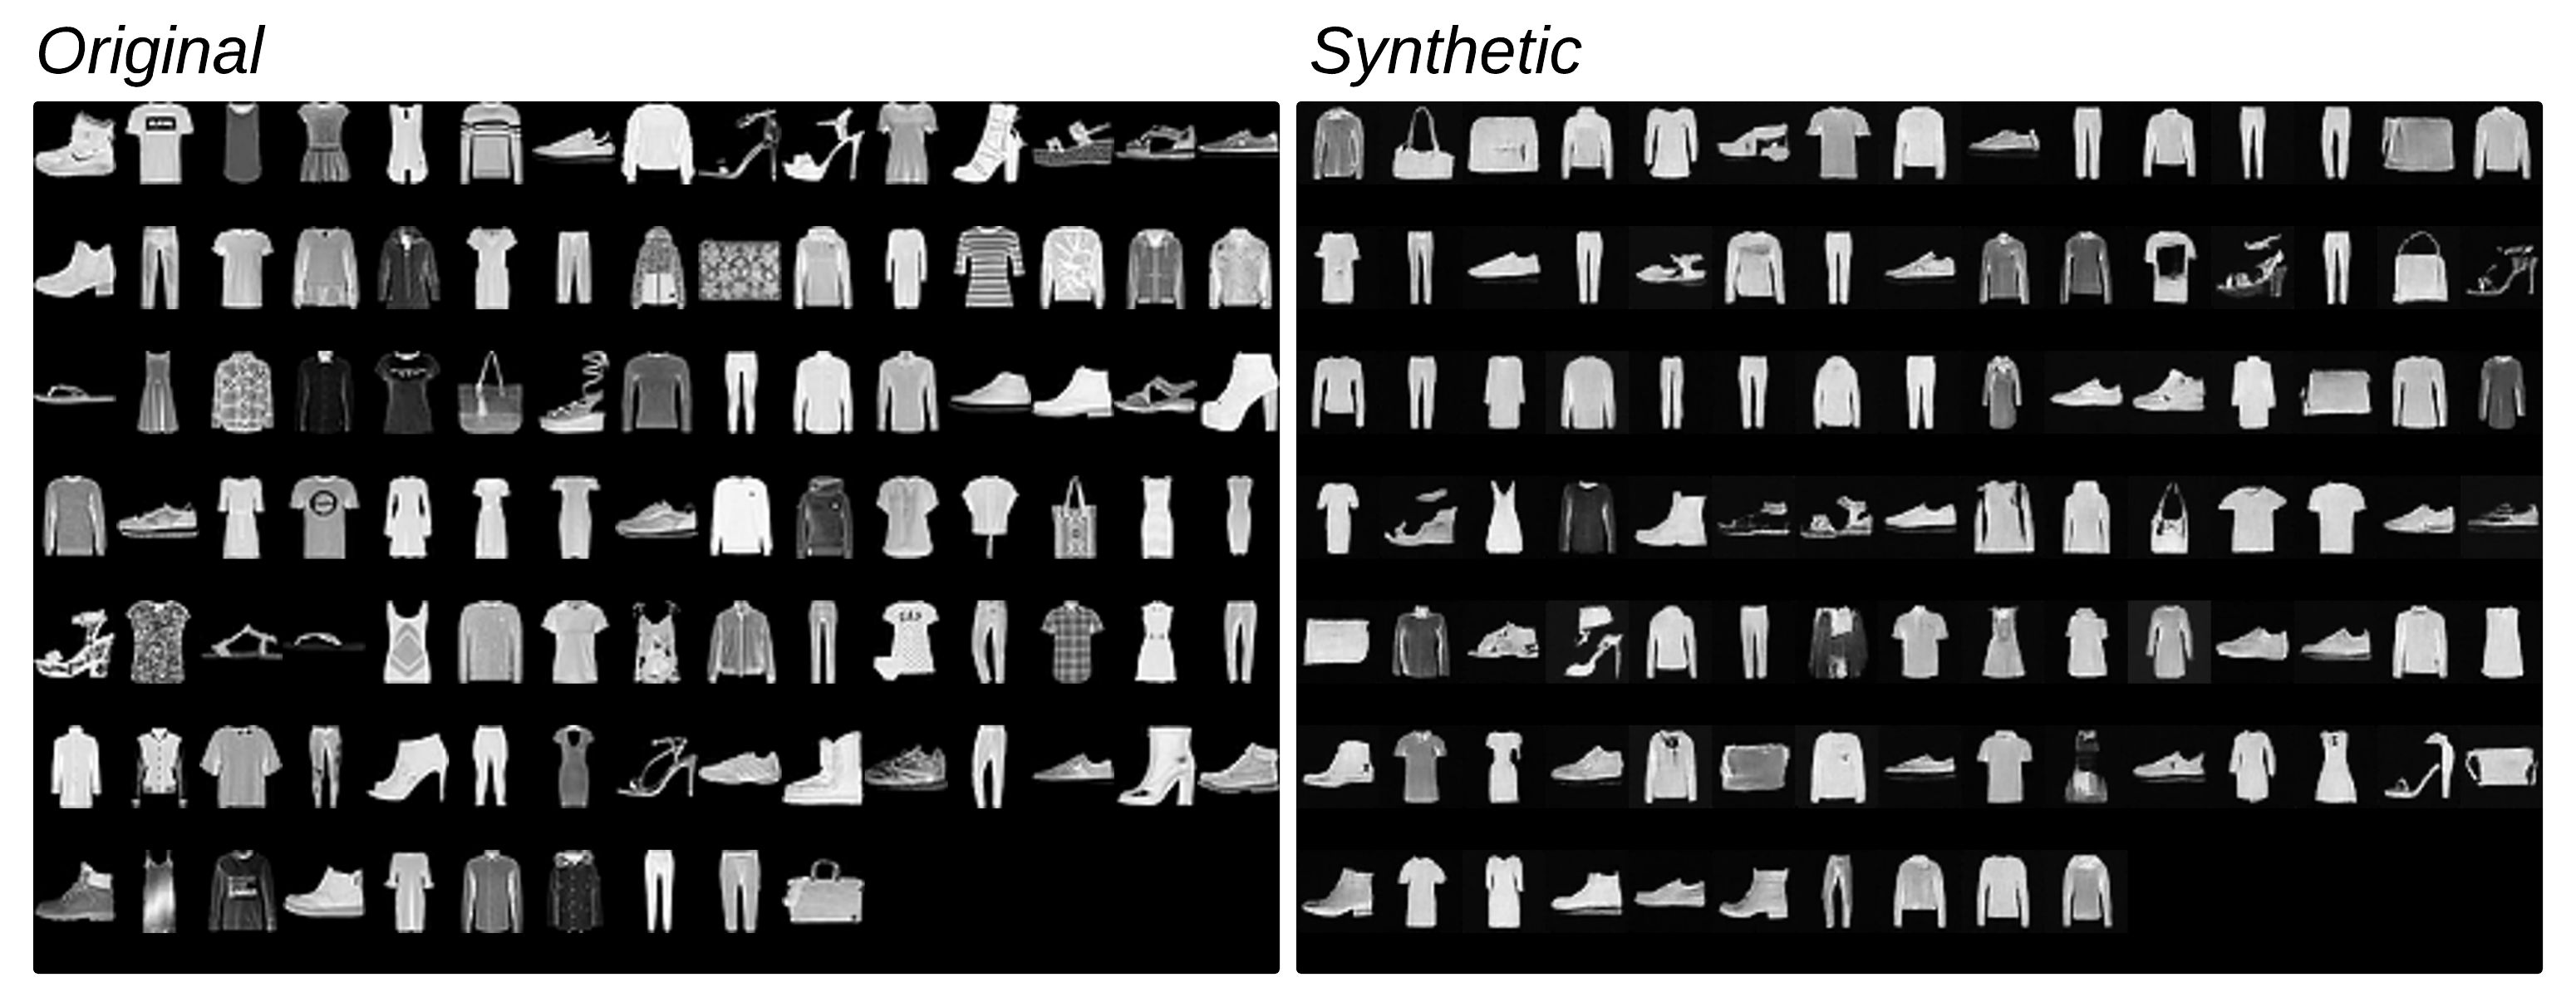

## 1. Forward Process

The process of adding noise of an input is represented by the posteior $q(x_{1:T}|x_0)$. According to the original DDPM paper, such distribution is fixed to a Markov Chain that gradually adds Gaussian noise the the data according to a **Variance Schedule** $\beta_1, ..., \beta_T$.

Also according to the paper, such sequence can be learned or held constant as hyperparameters. The latter approach is the one we are going to use, in which the sequence is an arithmetic progression with


$step = 0.02$, $\beta_1 = 1e-4$ and $T=1000$

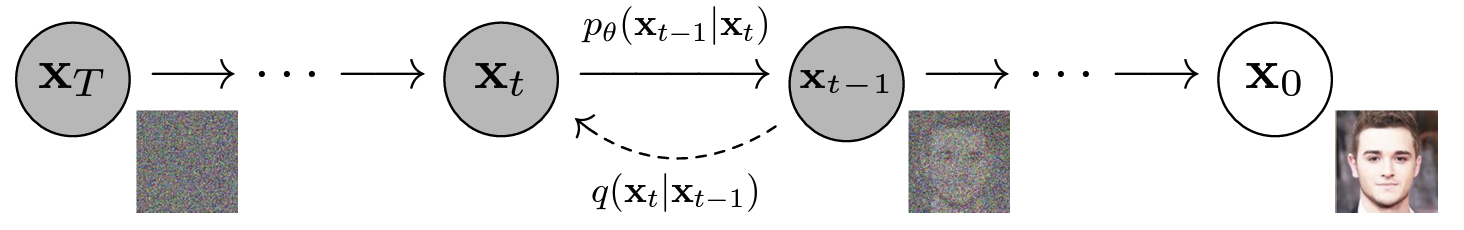
<p align="left">  <i> Image Extracted from the Medium Towards Data Science Post "Batch Norm Explained Visually — How it works, and why neural networks need it" </i> </p>

From the original DDPM paper, we know that in the forward process, a sample $x_t$ is produced by adding noise to a sample $x_{t-1}$ according to a normal distribution defined below:

\begin{align}
q(x_t|x_{t-1}) := N(x_{t}; \sqrt{1-\beta_t} \times x_{t-1}; \beta_tI)
\end{align}

Using this definition is not very feasible from an implementation point of view, because it makes the production of each noisy sample $x_{t}$ dependent on $x_{t-1}$. Ideally, one would need only $x_0$ to produce $x_t$ for any $t\geq0$. This is achieved by setting an alpha value defined below:


\begin{align}
\alpha_t &:= 1 - \beta_t \\
\bar{\alpha_t} &:= \prod_{s=1}^{t} a_s \\
\text{which lets us define}\\
q(x_t|x_0) &:= N(x_{t}; \sqrt{\bar{\alpha_t}} \times x_0; (1 - \bar{\alpha_t})I)
\end{align}

$\alpha_t$  represents the cumulative noise that's been added up to a time step `t`. Such parameter makes it possible for the forward chain to be completed only by having $t$ and $x_0$, which is ideal.








In the code below, we define the variance scheduler as the `DDPMScheduler`. The `self.alpha` attribute represents the cumulative noise that's been added up to a time step `t`. It is important to help in mantaining a  consistent relationship between the noisy data and the original one throughout the diffusion process

In [ ]:
class DDPMScheduler(nn.Module):
    def __init__(self, num_time_steps: int=1000):
        super().__init__()
        self.beta = torch.linspace(1e-4, 0.02, num_time_steps, requires_grad=False)
        alpha = 1 - self.beta
        self.alpha = torch.cumprod(alpha, dim=0).requires_grad_(False)

    def forward(self, t):
        return self.beta[t], self.alpha[t]

## 2. Reversion Process



The process of removing noise of an input is done by sampling from $p_{\theta}(x_{t-1} | x_t)$, such that:

\begin{align}
p_{\theta}(x_{t-1}|x_t) = N(x_{t-1}; \mu_{\theta}(x_t, t) x_{t-1}; \sigma_{t}^2I )
\end{align}

According to the paper, we will set $\sigma_{t}^2= \beta_t$.

To sample from $p_\theta$ is equivalent to the Reversion Process, which is the same as performing the following equation:

\begin{align}
x_{t-1} = \frac{1}{\sqrt{\alpha_t}}(x_t - \frac{\beta_t}{\sqrt{1-\bar{\alpha_t}}}\epsilon)
\end{align}

This is done by comparing $p_\theta(x_{t-1}|x_t)$ against $q(x_{t-1}|x_t,x_0)$.

Hence, in order to sample from $p_\theta$, we need a model $\epsilon_{\theta}(x_t, t)$ capable of approximating $\epsilon$.

Such model is a neural network with a U-Net-like architecture. Such model is used to predict $\epsilon$ that is removed from $x_{t}$ using the previous equation. This model has the following key components:



- **Sinusoidal Embeddings:** helps the model to keep track of an input $x_t$ position in the chain that leads to the denoised data $x_0$, i.e., gives the model information about $t$

- **Residual Layers**: important to improve the learning by sharing inputs directly between non-adjascent layers

- **Attention Mechanism**: allows the model to focus on different parts of an input's feature map, being able to determine the most important ones at each step. Moreover, it allows the model to learn long-range dependencies within an input.

Each of the components will be better defined in the following sections.


### 2.1 Sinusoidal Embeddings Definition ($SE$)

Sinusoidal Embeddings are a type of **Positional Embeddings** that embody the information of an input's position inside the input itself. Here, we will use the words input and embedding intercheangeably.

In the case of Diffusion Probabilistic Models, the position that input needs to embody is the **distance that it is from its denoised version.** In other words,each input $x_t$ to the model must store the information about how far $x_t$ is from $x_0$ so that just enough noise is taken out of the input image and it can generate the expected $x_0$.

### Sinusoidal Embeddings:

In every DDPM's Residual Layer, the input image tensor $x_t$ is transformed by the sinusoidal embedding that informs the model about the image's position relatively to $X_0$ in the Diffusion Process.

\begin{align}
    SE(x_t) &= x_t + (\sin(\omega_1 \cdot t), \cos(\omega_1 \cdot t), \sin(\omega_2 \cdot t), \cos(\omega_2 \cdot t), \cdots, \sin(\omega_{d_{model}/2} \cdot t),\cos(\omega_{d_{model}/2} \cdot t)) \\
    \omega_{2k} & = \frac{1}{10000^{k/d_{model}}} \text{, for even indices}\\
    \omega_{2k + 1 } & = \frac{1}{10000^{k/d_{model}}} \text{, for odd indices} \\
\end{align}

The definition above let's us conclude:
   - **Exponential Frequency Decay**: The $sin$ and $cos$ frequencies decrease exponetially as the number of the embeddings dimension ($d_{model}$) grows. This means that $SE$ values will repeat less often as $x_t$'s dimensions grow, which guarantees that embeddings $x_t$ and $x_{t+k}$ will be mapped to different vectors.
   - **Embeddings are linearly related**:  for any pair $X_t, X_{t+k}$, there is a linear transformation $M$ such that $M \times SE(X_t) = SE(X_{t+k})$

The linearity between embeddings means that should generalize to greater values of $T$ than those seem during training, because for any fixed offset $k$, $SE_{T+k}$ can be represented as a linear function of $SE_{T}$. The model must only learn such linear transformation

- *Why alternating $sin$ and $cos$?*

The short answer for this question is basically that such alternation is what makes the Linear Transformation affirmation hold. The proof for it is not that difficult, but is not in the scope of the present tutorial.

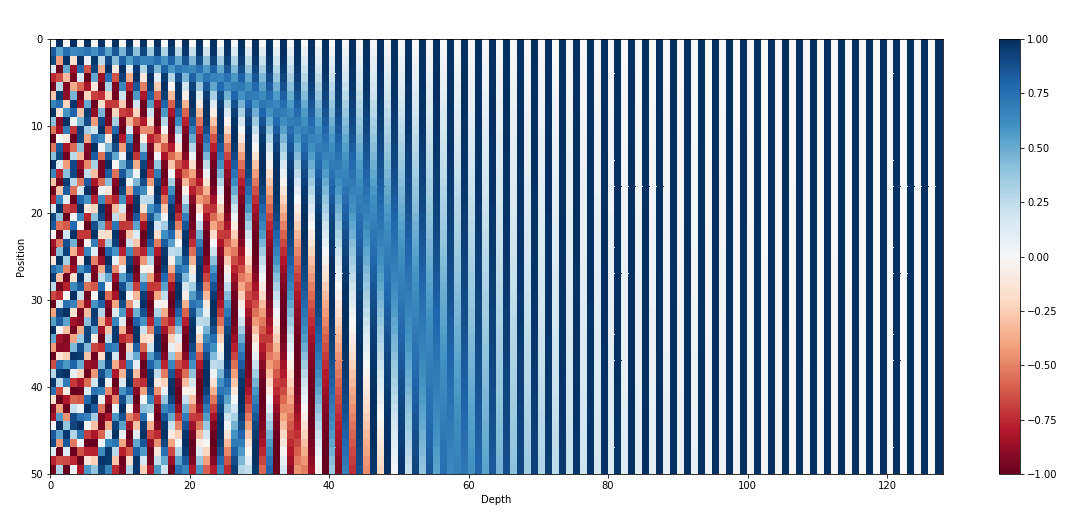



In [ ]:
class SinusoidalEmbeddings(nn.Module):

    def __init__(self, time_steps:int, embed_dim: int):
        super().__init__()
        position = torch.arange(time_steps).unsqueeze(1).float()
        div = torch.exp(torch.arange(0, embed_dim, 2).float() * -(math.log(10000.0) / embed_dim))
        embeddings = torch.zeros(time_steps, embed_dim, requires_grad=False)
        embeddings[:, 0::2] = torch.sin(position * div) # We use sin for even indices
        embeddings[:, 1::2] = torch.cos(position * div) # We use cos for odd indices
        self.embeddings = embeddings

    def forward(self, x, t):
        embeds = self.embeddings[t].to(x.device)
        return embeds[:, :, None, None]

### 2.2 Convolutional Residual Blocks



Convolutional Residual blocks can be visualized in the following figure:

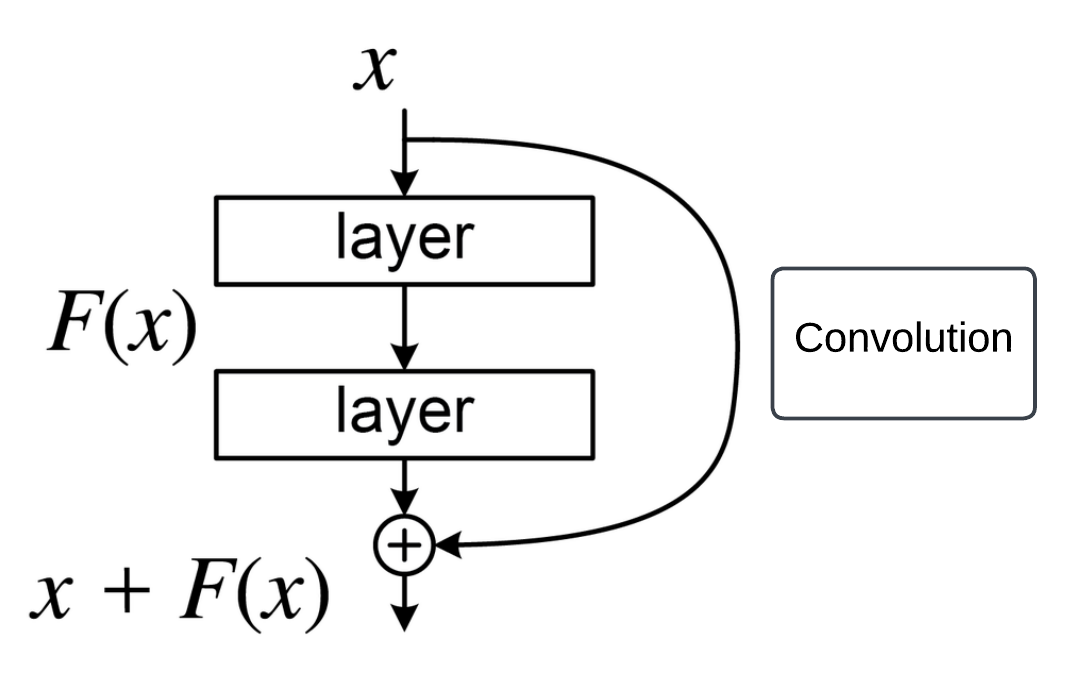


As can be visualized in the image above, **Residual Blocks permit that inputs skip some layers of the network**. This approach has many advantages, and the most important are defined below:



- **Mitigation of Vanishing/Exploding Gradients**: they help in addressing the vanishing and exploding gradient problems that are common in very deep networks. By providing shortcut connections, they allow gradients to flow directly through these connections, making it easier to train deep networks.

- **Identity Funcions Learning (Identity Residual Blocks)**: when the shortcut is made of an identity function instead of a convolution as in the image above, such shortcut allow the network to learn mappings where the output is the same as the input more easily, which helps in stabilizing the training process.

In [ ]:
class ResBlock(nn.Module):
    def __init__(self, in_channels: int, num_groups: int, dropout_prob: float):
        super().__init__()
        self.relu = nn.ReLU(inplace=True)
        self.gnorm1 = nn.GroupNorm(num_groups=num_groups, num_channels=in_channels)
        self.gnorm2 = nn.GroupNorm(num_groups=num_groups, num_channels=in_channels)
        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=in_channels, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=in_channels, out_channels=in_channels, kernel_size=3, padding=1)
        self.dropout = nn.Dropout(p=dropout_prob, inplace=True)

    def forward(self, x, embeddings):
        x = x + embeddings[:, :x.shape[1], :, :]
        r = self.conv1(self.relu(self.gnorm1(x)))
        r = self.dropout(r)
        r = self.conv2(self.relu(self.gnorm2(r)))
        return r + x

### 2.3 Attention Blocks



Logically, the Attention mechanism has one linear layer to produce each one its inputs: one for the $Query$, one for the $Key$ and another one for the $Value$. However, in practice we can use a single linear layer to produce $Q$, $K$ and $V$ simultaneously in the same data matrix/tensor in which each dimension represents one of such elements separately.

The same happens for the different attention heads. Even though each attention head works as separate attention mechanisms applied in different sets of $Q, K$ and $V$ from which the results are concatenated in the end, one does not need to have different data matrice/tensors for each attention head. Instead, one can place $Q, K$ and $V$ in the same tensor such that there are different sections/partitions for each attention head.When the $\text{Scaled Dot Product Attention}$ is applied over the tensor containing the all the heads' partitions to produce an output, each head

\begin{equation}
\text{MultiHead}(Q, K, V) = \text{Concat}(\text{head}_1, \ldots, \text{head}_h)W^O
\end{equation}

Where each head is computed as:

\begin{equation}
\text{head}_i = \text{Attention}(QW^Q_i, KW^K_i, VW^V_i)
\end{equation}

The attention function for each head is computed as:

\begin{equation}
\text{Attention}(Q, K, V) = \text{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right)V
\end{equation}

Where:

$\bullet$ $Q$, $K$, and $V$ are query, key, and value matrices, respectively

$\bullet$ $d_k$ is the dimension of the keys

$\bullet$ $W^Q_i$, $W^K_i$, $W^V_i$ are learned parameter matrices for each head

$\bullet$ $W^O$ is a learned parameter matrix for the output

$\bullet$ $h$ is the number of attention heads


Our attention module has the following requirements:



1. In order to produce $Q$, $K$ and $V$, we need to project an input $x$ into a new space that has $3$ times its original dimension, one for the $Q$, one for $K$ and one for $V$.

2. From the new space's output matrices for $Q$, $K$ and $V$, we need to interpret one of its dimension's size as: $NumberOfHeads \times NumberOfChannels$, because we need :
    -
    - Each of the $3$ elements has a set of matrix's entries/weights for each head for each channel.


In [ ]:
! pip install einops

In [ ]:
class Attention(nn.Module):
    def __init__(self, C: int, num_heads:int , dropout_prob: float):
        super().__init__()
        self.proj1 = nn.Linear(C, C*3) # This will output a tensor with 3 times the number of dimensions
        self.proj2 = nn.Linear(C, C)
        self.num_heads = num_heads
        self.dropout_prob = dropout_prob

    def forward(self, x):
        h, w = x.shape[2:]

        # We need to flatten the input image, moving from one dimension for
        # height (h) and another for width (w) to a single one for length (L)
        x = rearrange(x, 'b c h w -> b (h w) c')

        # Projeting the input to a 3 times larger dimension.
        # This projection holds the learned parameters for each attention head
        x = self.proj1(x)

        # Rearanging the projected tensor so the Q, K and V can be extracted from it
        # We will also consider one part of
        x = rearrange(x, 'b L (C H K) -> K b H L C', K=3, H=self.num_heads)
        q,k,v = x[0], x[1], x[2]

        x = F.scaled_dot_product_attention(q,k,v, is_causal=False, dropout_p=self.dropout_prob) # This will apply the scaled dot product attention
        # The attention mechanism operates on a flattened version of the spatial dimensions.
        # After attention, we need to restore the original spatial dimensions (h and w) for further processing,
        # such as convolutional layers or other spatial operations. We also need to concatenate each head's output
        # in a single dimension of length (C*H) to be able to apply the linear projection to the output of the attention mechanism.
        x = rearrange(x, 'b H (h w) C -> b h w (C H)', h=h, w=w)

        # This is the multi head Wo output matrix
        x = self.proj2(x)
        return rearrange(x, 'b h w C -> b C h w')

### 2.4 U-Net Layer



According to the original DDPM paper, each layer of the implemented U-NET model has:

- Two convolutional residual blocks per resolution level

- Self-attention blocks at the 16 × 16 resolution between the convolutional blocks



Such layer is implemented below.


In [ ]:
class UnetLayer(nn.Module):
    def __init__(self,
            upscale: bool,
            attention: bool,
            num_groups: int,
            dropout_prob: float,
            num_heads: int,
            C: int):
        super().__init__()
        self.ResBlock1 = ResBlock(in_channels=C, num_groups=num_groups, dropout_prob=dropout_prob)
        self.ResBlock2 = ResBlock(in_channels=C, num_groups=num_groups, dropout_prob=dropout_prob)
        if upscale:
            # Transposed Convolutions are made of kernels that restores the dimensions of an input
            self.conv = nn.ConvTranspose2d(C, C//2, kernel_size=4, stride=2, padding=1)
        else:
            self.conv = nn.Conv2d(C, C*2, kernel_size=3, stride=2, padding=1)
        if attention:
            self.attention_layer = Attention(C, num_heads=num_heads, dropout_prob=dropout_prob)

    def forward(self, x, embeddings):
        x = self.ResBlock1(x, embeddings)
        if hasattr(self, 'attention_layer'):
            x = self.attention_layer(x)
        x = self.ResBlock2(x, embeddings)
        return self.conv(x), x

### 2.5. Denoiser Model: The U-Net





The U-Net model is composed of two types of layers set:

- **Contracting path**: the input's height and width are successively reduced by multiple convolutional filters, while its channels increase

- **Expanding path**: the opposite happens, i.e., the input's height and width are successively increased, while its channels decrease

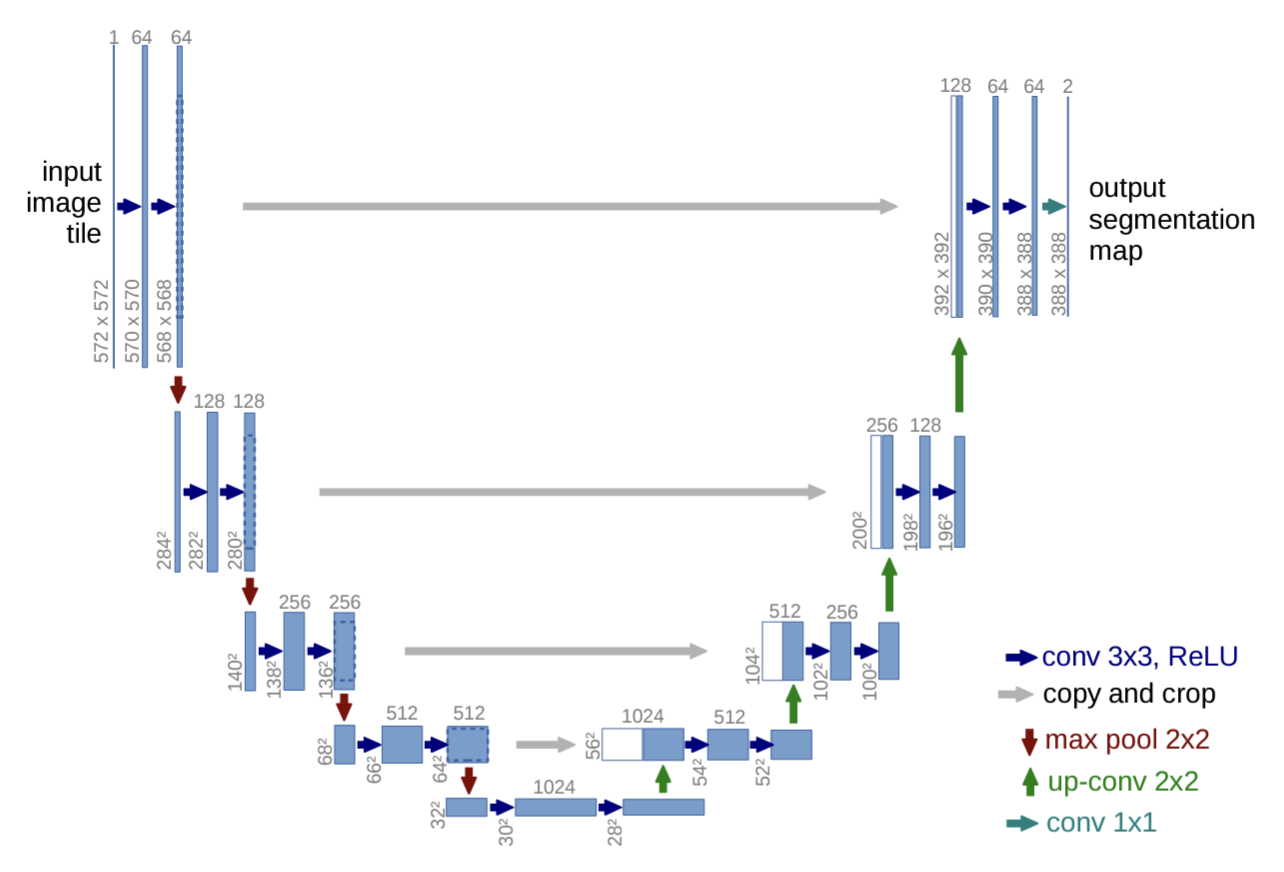

<p align="left">  <i> Image Extracted from the original paper: "U-Net: Convolutional Networks for Biomedical Image Segmentation" </i> </p>

In [ ]:
class UNET(nn.Module):
    def __init__(self,
            Channels: List = [64, 128, 256, 512, 512, 384],
            Attentions: List = [False, True, False, False, False, True], #We'll use this list to mark the layers where we want to use the attention mechanism
            Upscales: List = [False, False, False, True, True, True], #We'll use this list to mark differentiate the contracting and expanding paths/layers
            num_groups: int = 32,
            dropout_prob: float = 0.1,
            num_heads: int = 8,
            input_channels: int = 1,
            output_channels: int = 1,
            time_steps: int = 1000):

        super().__init__()
        self.num_layers = len(Channels)
        self.shallow_conv = nn.Conv2d(input_channels, Channels[0], kernel_size=3, padding=1)

        out_channels = (Channels[-1]//2)+Channels[0]
        self.late_conv = nn.Conv2d(out_channels, out_channels//2, kernel_size=3, padding=1)
        self.output_conv = nn.Conv2d(out_channels//2, output_channels, kernel_size=1)
        self.relu = nn.ReLU(inplace=True)
        self.embeddings = SinusoidalEmbeddings(time_steps=time_steps, embed_dim=max(Channels))

        for i in range(self.num_layers):
            layer = UnetLayer(
                upscale=Upscales[i],
                attention=Attentions[i],
                num_groups=num_groups,
                dropout_prob=dropout_prob,
                C=Channels[i],
                num_heads=num_heads
            )
            setattr(self, f'Layer{i+1}', layer)

    def forward(self, x, t):
        # This is performed to increase the initial image's channels
        x = self.shallow_conv(x)

        # We'll keep the residuals, i.e., intermediate outputs to perform the copy and crop operations
        # from the U-Net architecture
        residuals = []
        for i in range(self.num_layers//2):
            layer = getattr(self, f'Layer{i+1}')
            embeddings = self.embeddings(x, t)
            x, r = layer(x, embeddings)
            residuals.append(r)

        for i in range(self.num_layers//2, self.num_layers):
            layer = getattr(self, f'Layer{i+1}')

            # Copy and crop: concatenating the upscale layer's outputs to the corresponding
            # downscale layer's output
            x = torch.concat((layer(x, embeddings)[0], residuals[self.num_layers-i-1]), dim=1)

        return self.output_conv(self.relu(self.late_conv(x)))

## 3. Dataset Loading



We will begin by loading the FashionMNIST dataset from `torchvision`, which is a package that "consists of popular datasets, model architectures, and common image transformations for computer vision". For each data sample of the dataset, we will apply two transformations described below.



### Data Transformations



- `ToTensor`: this transformation converts a `PIL` image or `numpy` array with shape $\text{(Height x Width x Channels)}$ in the range $[0,255]$ to a `torch.FloatTensor` of shape $\text{(Channels x Height x Width)}$ in the range $[0,1]$

- `Normalize`: subtracts a constant value from each pixel and divides the result by another constant. We will use:

\begin{align}
  \text{Normalized Pixel} &= \frac{(\text{pixel} - c_1)}{c_2}. \\
  c_1 &= 0.5 \\
  c_2 &= 0.5
\end{align}



After such transformations we all of the dataset tensor's values will be in the range $[-1,1]$. Such range is desirable for training stability and some activations functions like the `tanh` that naturally output values in this range.

In [ ]:
dataset = datasets.FashionMNIST(
    root="./data",
    train=True,
    download=True,
    transform=transforms.ToTensor(),
)

batch_size = 64
dataloader = DataLoader(
    dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=4,
    drop_last=True
)

100%|██████████| 26.4M/26.4M [00:02<00:00, 11.8MB/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 199kB/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:01<00:00, 3.73MB/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 4.41MB/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw




/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


## 4. Training

In the training loop of our DDPM, both the forward and reverse processes are performed. We will also keep track of the model's parameters' **Exponential Moving Average (EMA)** that lets us use the such moving average value as the weights instead of the weights directly. This can help improve the stability and performance of the model, especially when the model parameters are noisy or fluctuate a lot during training.

The hyperparameters have not been optimized. Their values are just the same as the model trained on the original MNIST dataset in which the present tutorial is based on.

In the following cell, we implement the original paper's training algorithm:


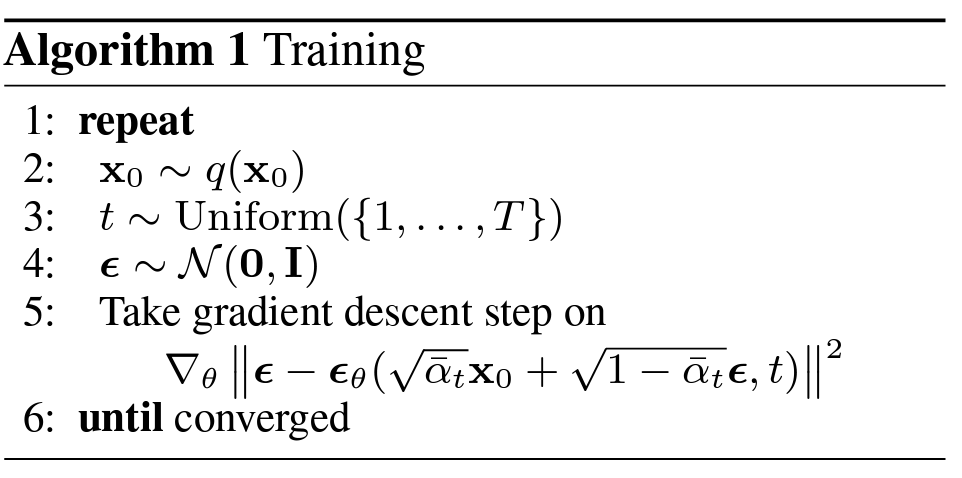
<p align="left">  <i> Image Extracted from the DDPM original paper: "Denoising Diffusion Probabilistic Models" </i> </p>




In [ ]:
# This function defines a training seed. This means that if you
# want to reproduce a specific training instance you can use a
# set seed such that the random weight and optimizer initializations
# are the same each time you use the same seed.
def set_seed(seed: int = 42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)

def train(train_loader = dataloader,
          batch_size: int=batch_size,
          num_time_steps: int=1000,
          num_epochs: int=15,
          seed: int=-1,
          ema_decay: float=0.9999,
          lr=2e-5,
          checkpoint_path: str = None,
          checkpoint_dir: str = output_folder,
          checkpoint_interval: int = 5):

    os.makedirs(checkpoint_dir, exist_ok=True)
    set_seed(random.randint(0, 2**32-1)) if seed == -1 else set_seed(seed)
    scheduler = DDPMScheduler(num_time_steps=num_time_steps)
    model = UNET().cuda()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    ema = ModelEmaV3(model, decay=ema_decay)

    if checkpoint_path is not None:
        checkpoint = torch.load(checkpoint_path)
        model.load_state_dict(checkpoint['weights'])
        ema.load_state_dict(checkpoint['ema'])
        optimizer.load_state_dict(checkpoint['optimizer'])

    criterion = nn.MSELoss(reduction='mean')
    os.makedirs(checkpoint_dir, exist_ok=True)
    last_step = checkpoint_path.split('/')[-1].split('_')[-1].split('.')[0] if checkpoint_path is not None else 0
    last_step = int(last_step)

    for i in range(last_step, num_epochs):
        total_loss = 0
        for bidx, (x,_) in enumerate(tqdm(train_loader, desc=f"Epoch {i+1}/{num_epochs}")):
            x = x.cuda()
            x = F.pad(x, (2,2,2,2))
            batch_size_actual = x.size(0)
            t = torch.randint(0,num_time_steps,(batch_size,))

        # ------------
        # Forward process
        # ------------
            # This is the noise that will be added to the input according to the variance scheduler
            e = torch.randn_like(x, requires_grad=False)

            # Produces the alpha value that will be used to sample from the forward noise-adding
            # distribution
            a = scheduler.alpha[t].view(batch_size,1,1,1).cuda()

            # Adds the gaussian noise to the input, which is the forward pass, according to
            # the q distribution
            x = (torch.sqrt(a)*x) + (torch.sqrt(1-a)*e)

        # ------------
        # Reverse process
        # ------------
            # Predicts the noise from the input, which is the reverse process performed by the model
            output = model(x, t)
            optimizer.zero_grad()
            loss = criterion(output, e)
            total_loss += loss.item()
            loss.backward()
            optimizer.step()
            ema.update(model)
        print(f'Epoch {i+1} | Loss {total_loss / (60000/batch_size):.5f}')

        # Save checkpoint at specified intervals
        if (i + 1) % checkpoint_interval == 0 or (i + 1) == num_epochs:
            checkpoint = {
                'weights': model.state_dict(),
                'optimizer': optimizer.state_dict(),
                'ema': ema.state_dict()
            }
            checkpoint_filename = os.path.join(checkpoint_dir, f'ddpm_checkpoint_epoch_{i + 1}.pth')
            torch.save(checkpoint, checkpoint_filename)
            print(f'Checkpoint saved at {checkpoint_filename}')

In [ ]:
if TRAIN_NEW_MODEL:
  train(lr=2e-5, num_epochs=75)

## 5. Inference

In the following cell, we implement the original paper's inference/sampling algorithm:

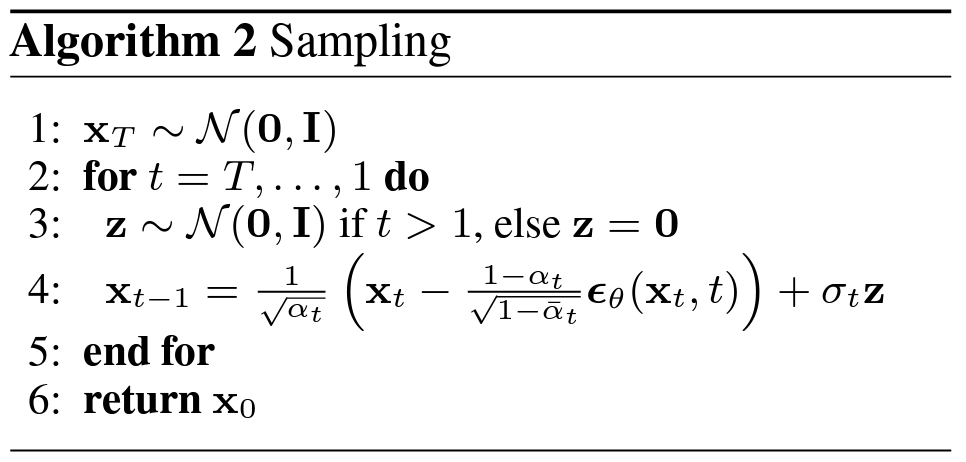
<p align="left">  <i> Image Extracted from the DDPM original paper: "Denoising Diffusion Probabilistic Models" </i> </p>

In [ ]:
def display_reverse(images: List):
    fig, axes = plt.subplots(1, 10, figsize=(10,1))
    for i, ax in enumerate(axes.flat):
        x = images[i].squeeze(0)
        x = rearrange(x, 'c h w -> h w c')
        x = x.numpy()
        ax.imshow(x)
        ax.axis('off')
    plt.show()

def inference(checkpoint_path: str=None,
              num_time_steps: int=1000,
              ema_decay: float=0.9999,
              n_samples: int = 5):
    checkpoint = torch.load(checkpoint_path)
    model = UNET().cuda()
    model.load_state_dict(checkpoint['weights'])
    ema = ModelEmaV3(model, decay=ema_decay)
    ema.load_state_dict(checkpoint['ema'])
    scheduler = DDPMScheduler(num_time_steps=num_time_steps)

    # We will store the partially denoised images at some
    # time steps (for some values of t)
    times = [0,15,50,100,200,300,400,550,700,999]
    images = []
    output = []
    with torch.no_grad():
        model = ema.module.eval()
        for i in range(n_samples):

            # This is the line 2 of the sampling algorithm, i.e.,
            # z = x_{T}
            z = torch.randn(1, 1, 32, 32)

            # We will disregard t = 0 and consider it on the outside
            # of the loop
            for t in reversed(range(1, num_time_steps)):
                t = [t]

                # This temporary variable stores the model's multiplier coefficient from the line 4 of the
                # sampling algorithm
                temp = (scheduler.beta[t]/((torch.sqrt(1-scheduler.alpha[t]))*(torch.sqrt(1-scheduler.beta[t]))))

                # Here z is equivalent to x_{t-1}. Hence, this line is denoising x_{t}
                z = (1/(torch.sqrt(1-scheduler.beta[t])))*z - (temp*model(z.cuda(),t).cpu())
                if t[0] in times:
                    images.append(z)
                e = torch.randn(1, 1, 32, 32)

                # There is still the \sigma * z to be added to the denoised image
                # we will use \sigma = \beta{t} as performed in the DDPM paper
                z = z + (e*torch.sqrt(scheduler.beta[t]))

            # t = 0 here
            temp = scheduler.beta[0]/( (torch.sqrt(1-scheduler.alpha[0]))*(torch.sqrt(1-scheduler.beta[0])))

            # This is the fully denoised image, i.e., x_{0}
            x = (1/(torch.sqrt(1-scheduler.beta[0])))*z - (temp*model(z.cuda(),[0]).cpu())

            output.append(x.detach().cpu())
            images.append(x)
            x = rearrange(x.squeeze(0), 'c h w -> h w c').detach()
            x = x.numpy()
            plt.imshow(x)
            plt.show()
            display_reverse(images)
            images = []
    return output


<ipython-input-13-97253d30f116>:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


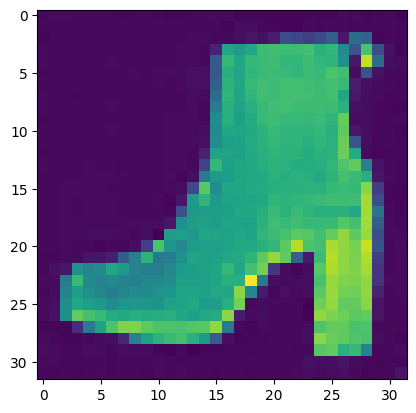

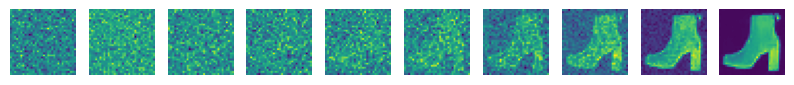

In [ ]:
n_samples = 1
samples = inference(trained_model_path, n_samples=n_samples)

In [ ]:
def display_generated_images(gen_imgs: List,
                                cell_width: float,
                                cell_height: float,
                                num_images: int = 5) -> Image:

    num_images = len(gen_imgs)
    n_cols = 15
    n_rows = num_images // n_cols + (1 if num_images % n_cols != 0 else 0)
    full_img = Image.new("RGB", (n_cols * cell_width, n_rows * cell_height))

    def tensor_to_numpy(tensor):
        if tensor.is_cuda:
            tensor = tensor.cpu()

        # Remove the batch dimension and channel dimension
        img = tensor.squeeze().numpy()
        rescaled_img = cv2.normalize(img, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
        return rescaled_img

    for i, img in enumerate(gen_imgs):
        img = tensor_to_numpy(img)
        img = Image.fromarray(img)
        if img.width > img.height:
            img = img.transpose(method=Image.Transpose.ROTATE_270)

        prop = img.width / img.height

        col = i % n_cols
        row = i // n_cols

        x = col * cell_width
        y = row * cell_height

        new_width = cell_width
        new_height = int(cell_width / prop)
        img = img.resize((new_width, new_height))
        full_img.paste(img, (x, y))
    full_img = np.array(full_img)
    return full_img

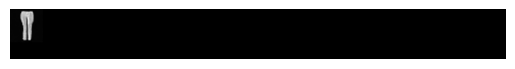

In [ ]:
img = display_generated_images(gen_imgs = samples, cell_width=100,cell_height=150, num_images=100)
plt.imshow(img, cmap='gray')
plt.axis('off')  # Hide the axis
plt.show()

In [ ]:
numpy_img = img.astype(np.uint8)  # Convert to unsigned 8-bit integer type
pil_img = Image.fromarray(numpy_img)